## CARGA DE DEPENDENCIAS

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import os

## CARGA DE DATOS

In [4]:
os.chdir('C:/Users/carlo/Documents/dm_prueba_t-cnica/')

In [5]:
# cargar datos
print("Cargando datos...")
df = pd.read_csv('data\cleaned_sales_data.csv', sep=';')
df.shape

Cargando datos...


(47945, 10)

In [6]:
df.head()

,order_id,customer_id,product_id,quantity,price,order_date,region,discount,shipping_priority,ingreso_neto
0,249093af-4bed-430f-a55d-73e8dd782870,7271.0,923.0,10.0,410.048837,2024-06-07,East,0.064040,Low,3837.894360
1,8da511f7-ef36-4a18-9b31-1b107876ce28,861.0,621.0,20.0,466.519110,2023-01-29,East,0.021410,Medium,9130.618725
2,db3b8b9c-4917-4ec5-a7df-1c661aa6b69c,5391.0,677.0,3.0,35.175263,2023-09-24,West,0.243724,Medium,79.806574
3,4aeec22a-d9bb-429c-9581-46068d89578a,5192.0,370.0,9.0,75.551426,2023-08-11,West,0.272166,Low,494.899766
4,1224d200-8fe1-4c9f-9ad2-546613fe1cc2,2416.0,941.0,15.0,61.812616,2024-08-09,East,0.233102,High,711.059595


## ANÁLISIS EXPLORATORIO

In [7]:
df['ingreso_diario_total'] = df.price * df.quantity

<Figure size 1600x800 with 0 Axes>

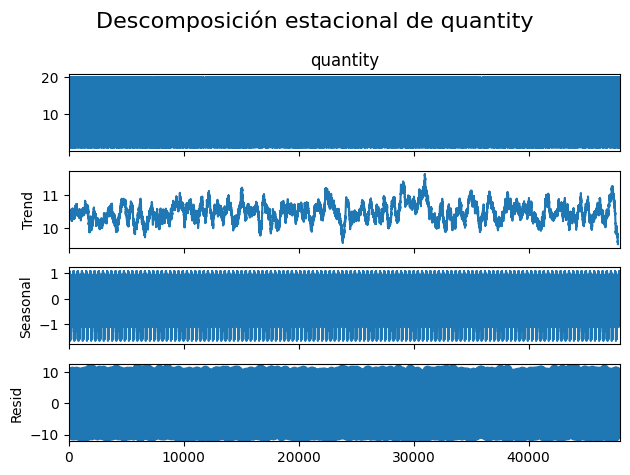

<Figure size 1600x800 with 0 Axes>

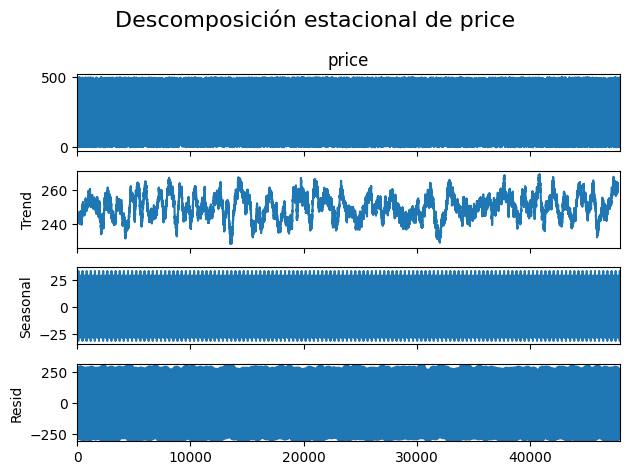

<Figure size 1600x800 with 0 Axes>

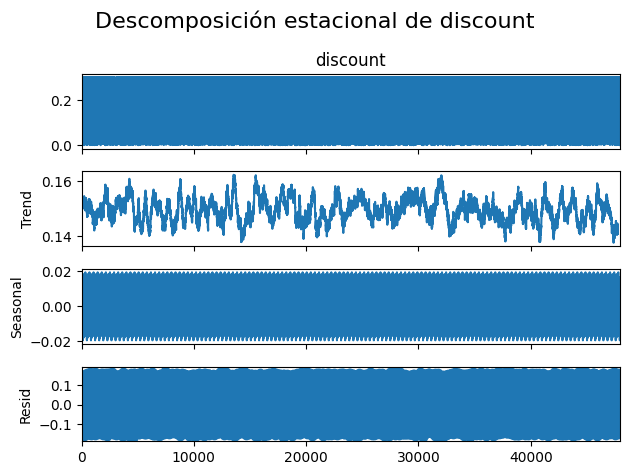

<Figure size 1600x800 with 0 Axes>

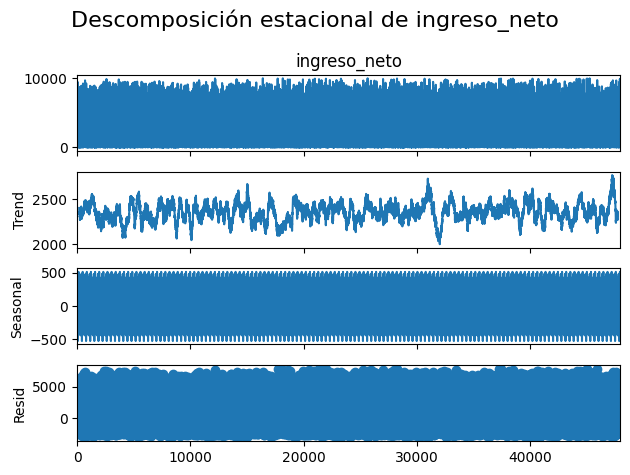

<Figure size 1600x800 with 0 Axes>

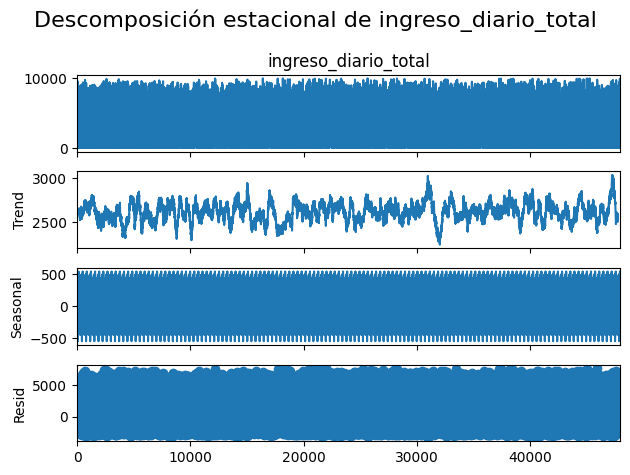

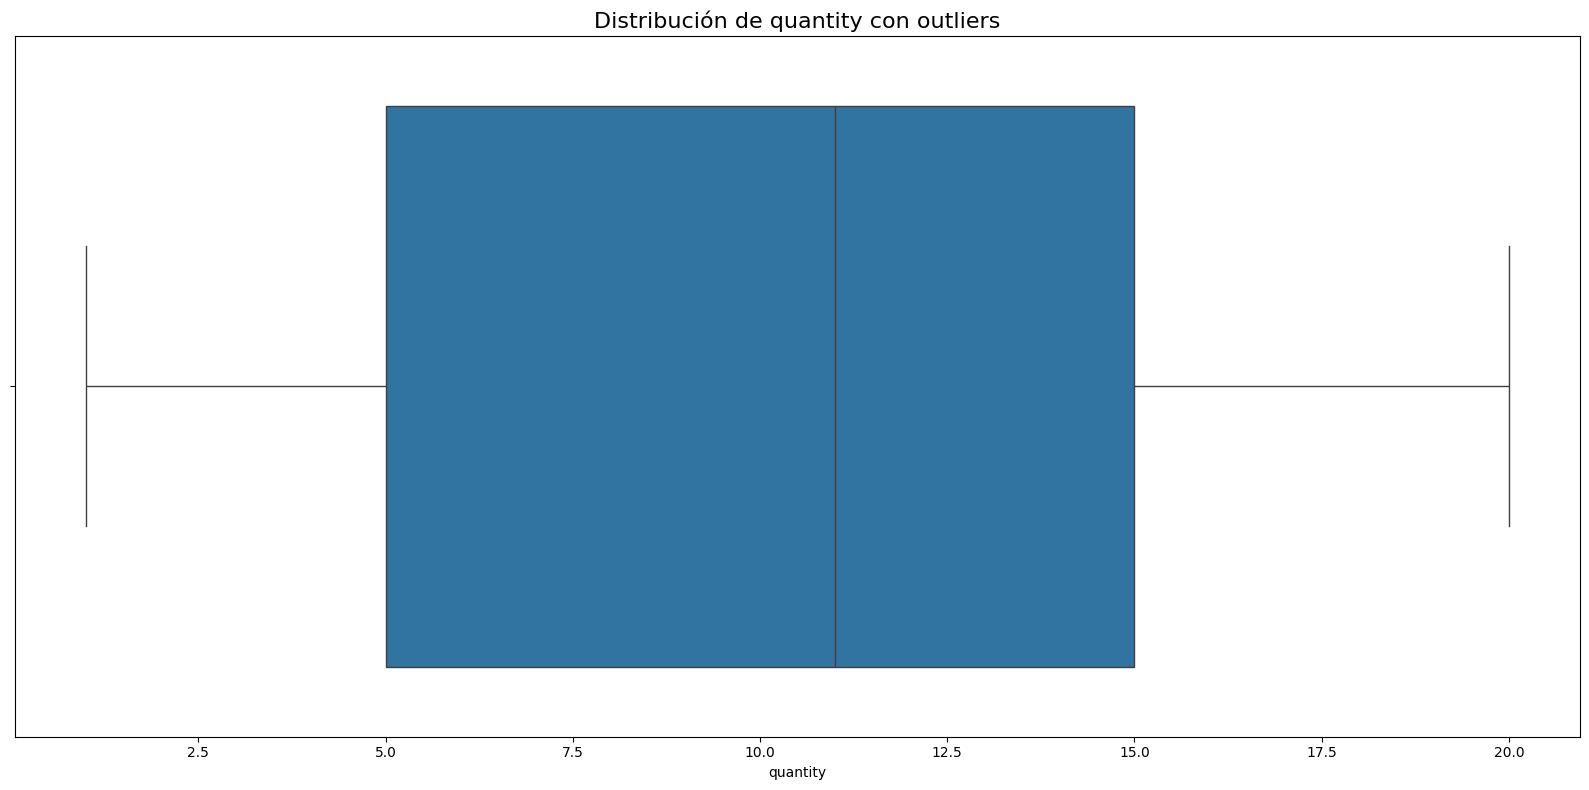

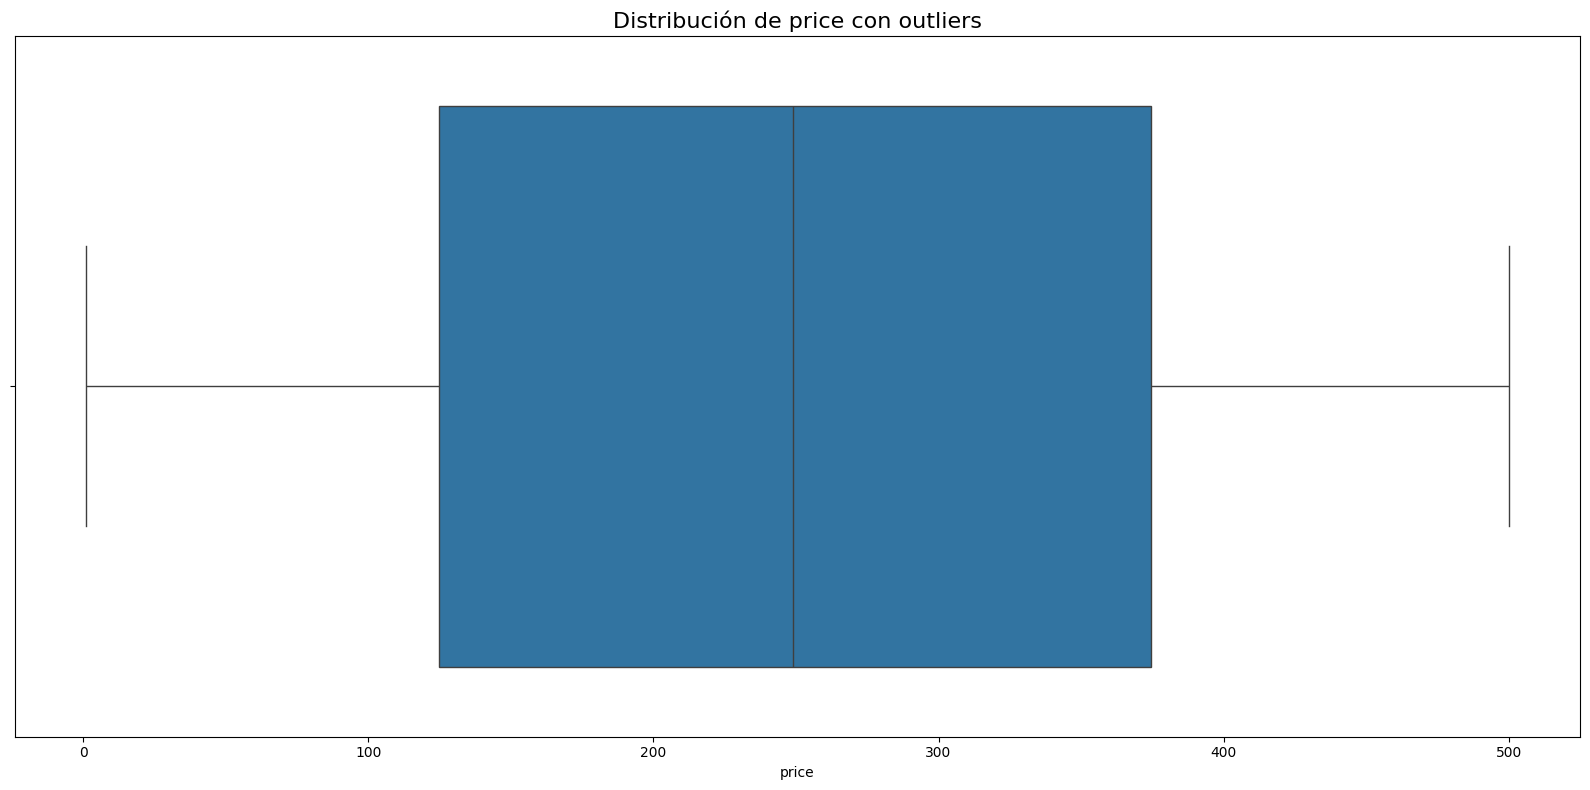

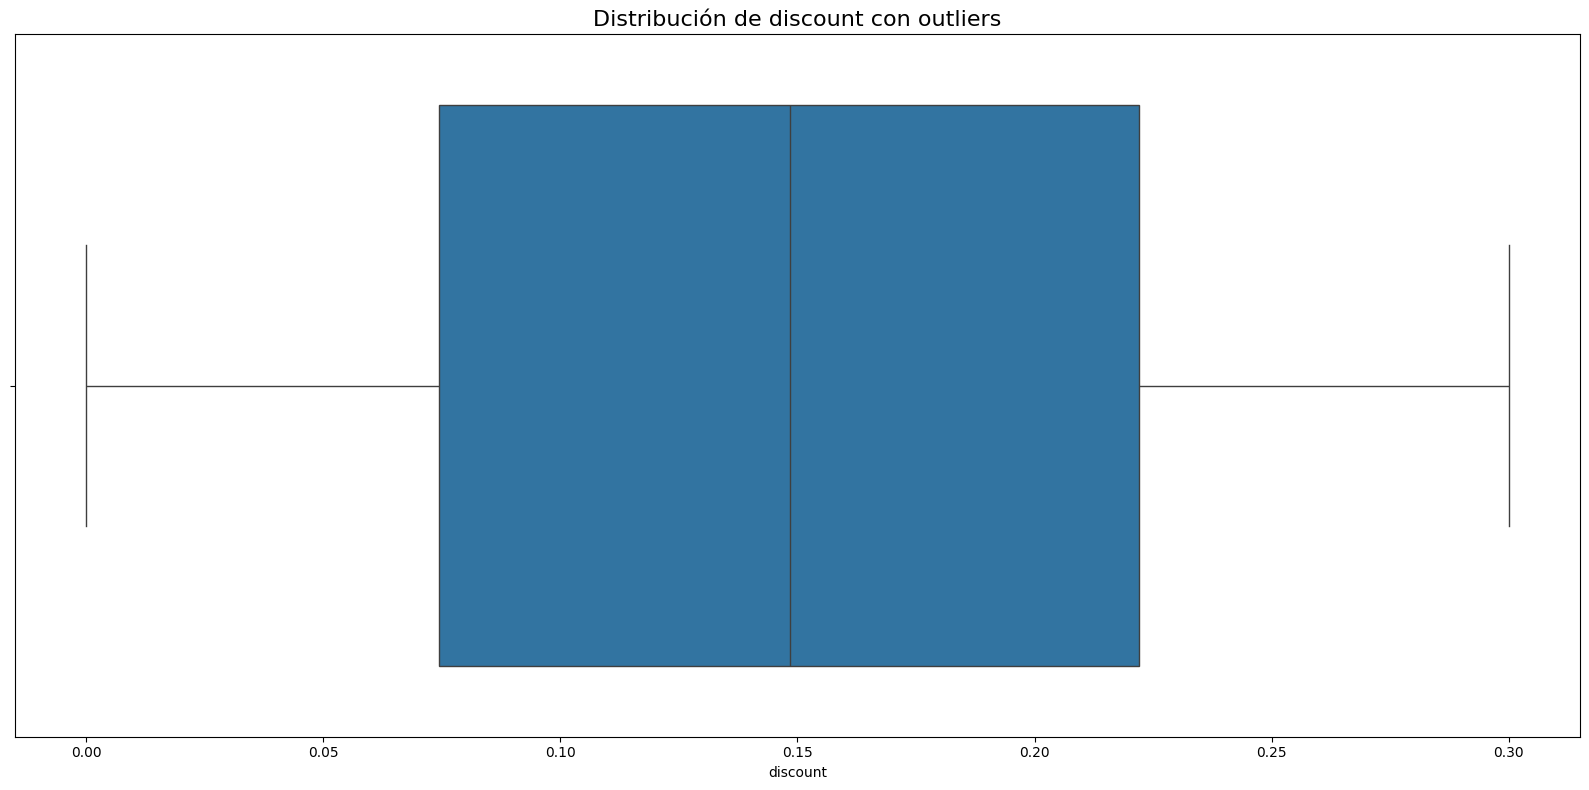

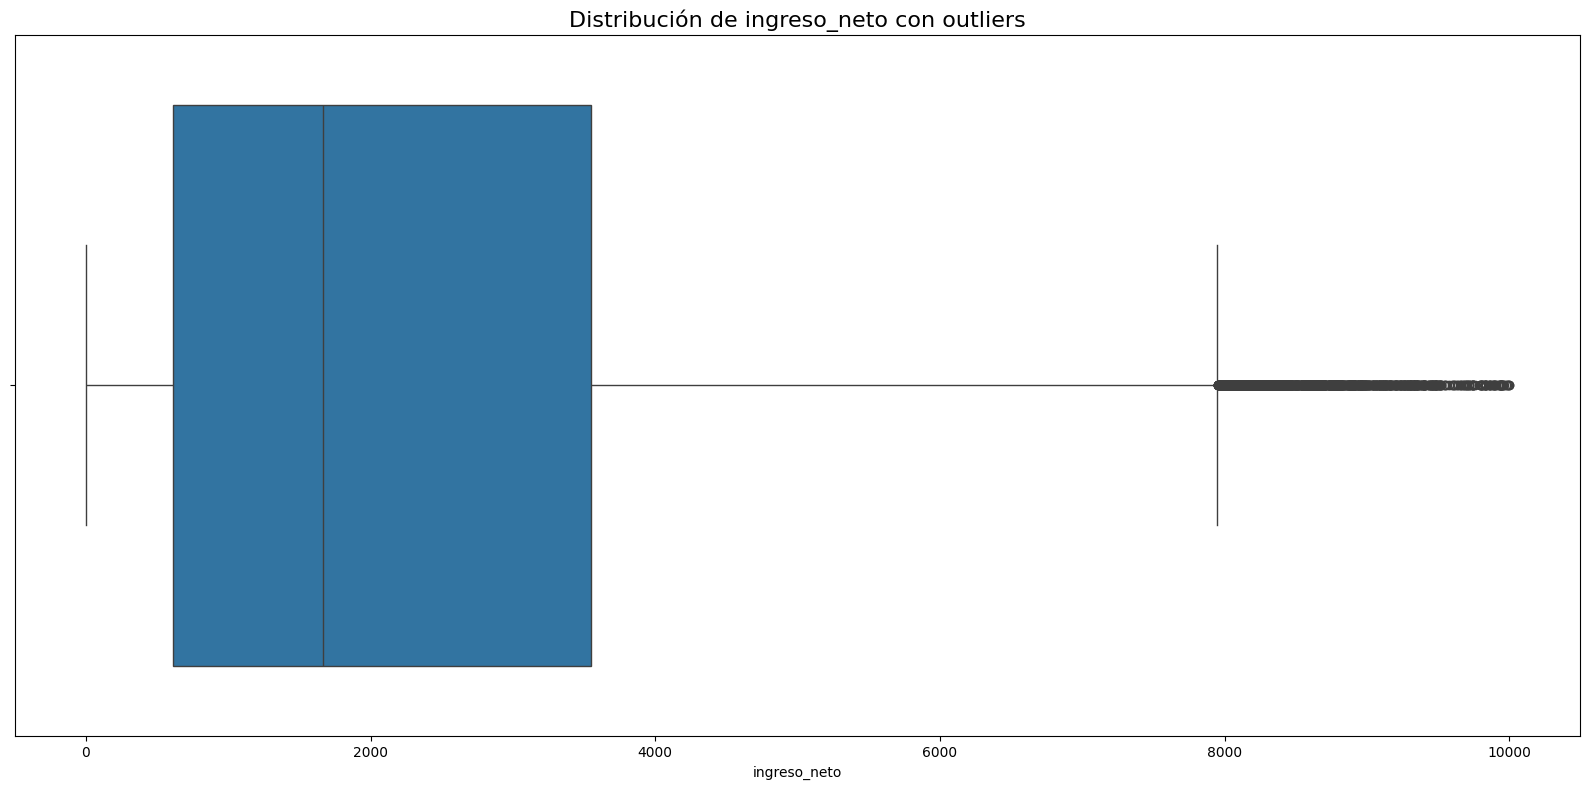

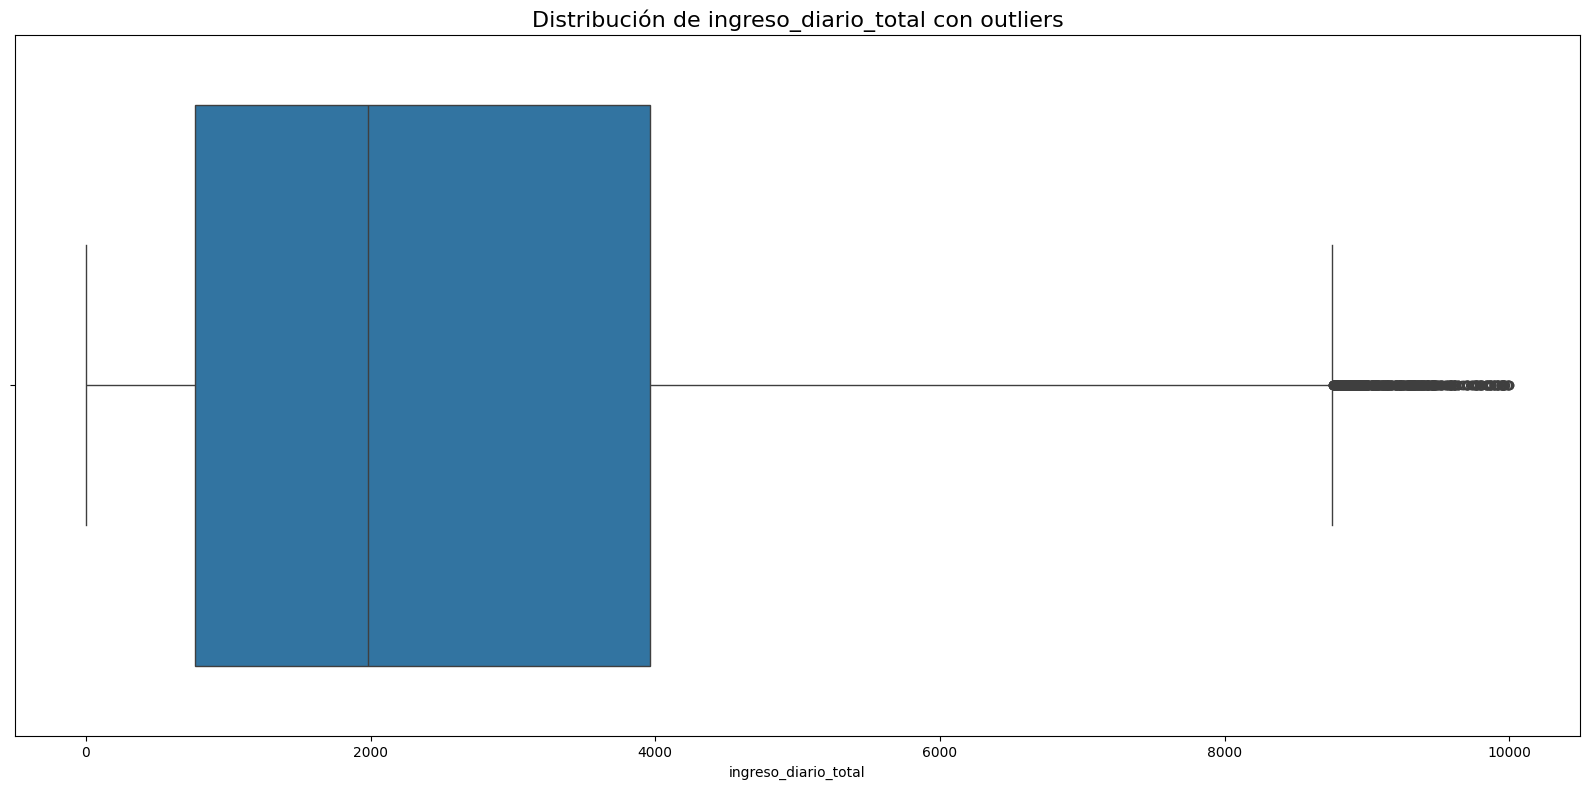

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Función 1: Análisis exploratorio
def exploratory_analysis(data):
    # Conversión de 'date' a formato datetime
    data['order_date'] = pd.to_datetime(data['order_date'])
    
    # Definición de las variables de interés
    variables = ['quantity', 'price', 'discount', 'ingreso_neto','ingreso_diario_total']
    
    # Descomposición estacional (descomposición aditiva) para cada variable
    for var in variables:
        plt.figure(figsize=(16, 8))  # Tamaño de gráfico mayor
        decomposition = seasonal_decompose(data[var], model='additive', period=365)  # Asumiendo datos diarios
        decomposition.plot()
        plt.suptitle(f"Descomposición estacional de {var}", fontsize=16)
        plt.tight_layout()
        plt.show()

    # Detectar outliers utilizando el método del IQR (Interquartile Range)
    outliers = {}
    for var in variables:
        Q1 = data[var].quantile(0.25)
        Q3 = data[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[var] = data[(data[var] < lower_bound) | (data[var] > upper_bound)]
    
    # Visualización de outliers para cada variable con gráficos de boxplot
    for var in variables:
        plt.figure(figsize=(16, 8))  
        sns.boxplot(x=data[var])
        plt.title(f"Distribución de {var} con outliers", fontsize=16)
        plt.tight_layout()
        plt.show()

    return outliers


outliers = exploratory_analysis(df)


## PREPROCESSING Y SPLIT

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [11]:
import pandas as pd

def crear_variables_dummy(df, columna_categorica):
    """Crea variables dummy a partir de una columna categórica.

    Args:
        df (pandas.DataFrame): DataFrame con los datos.
        columna_categorica (str): Nombre de la columna categórica.

    Returns:
        pandas.DataFrame: DataFrame con las variables dummy.
    """

    df = pd.get_dummies(df, columns=[columna_categorica], prefix=columna_categorica)
    return df


df = crear_variables_dummy(df, 'region')

In [12]:
df.head(3)

,order_id,customer_id,product_id,quantity,price,order_date,discount,shipping_priority,ingreso_neto,ingreso_diario_total,region_East,region_North,region_South,region_West
0,249093af-4bed-430f-a55d-73e8dd782870,7271.0,923.0,10.0,410.048837,2024-06-07,0.064040,Low,3837.894360,4100.488365,True,False,False,False
1,8da511f7-ef36-4a18-9b31-1b107876ce28,861.0,621.0,20.0,466.519110,2023-01-29,0.021410,Medium,9130.618725,9330.382198,True,False,False,False
2,db3b8b9c-4917-4ec5-a7df-1c661aa6b69c,5391.0,677.0,3.0,35.175263,2023-09-24,0.243724,Medium,79.806574,105.525788,False,False,False,True


In [13]:
def dividir_datos(X, y, test_size=0.2):
    """Divide los datos en conjuntos de entrenamiento y prueba, considerando variables dummy.

    Args:
        X (pandas.DataFrame): DataFrame con las características, incluyendo variables dummy.
        y (pandas.Series): Serie con la variable objetivo.
        test_size (float, optional): Proporción de datos para el conjunto de prueba. Defaults to 0.2.

    Returns:
        tuple: Tupla con los conjuntos de entrenamiento y prueba (X_train, X_test, y_train, y_test).
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test


X = df[['quantity', 'price', 'discount', 'region_East', 'region_North', 'region_South']]
y = df['ingreso_diario_total']

#split
X_train, X_test, y_train, y_test = dividir_datos(X, y)

## ENTRENAMIENTO RL Y RF

In [14]:
def entrenar_regresion_lineal(X_train, y_train):
    """Entrena un modelo de regresión lineal múltiple.

    Args:
        X_train (numpy.ndarray): Características de entrenamiento.
        y_train (numpy.ndarray): Variable objetivo de entrenamiento.

    Returns:
        sklearn.linear_model.LinearRegression: Modelo de regresión lineal entrenado.
    """

    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

modelo_rl = entrenar_regresion_lineal(X_train, y_train)

In [15]:
def entrenar_random_forest(X_train, y_train):
    """Entrena un modelo de Random Forest.

    Args:
        X_train (numpy.ndarray): Características de entrenamiento.
        y_train (numpy.ndarray): Variable objetivo de entrenamiento.

    Returns:
        sklearn.ensemble.RandomForestRegressor: Modelo de Random Forest entrenado.
    """

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model

modelo_rf = entrenar_random_forest(X_train, y_train)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluar_modelo(model, X_test, y_test):
    """
    Evalúa el rendimiento de un modelo.

    Args:
        model: Modelo entrenado.
        X_test (numpy.ndarray): Características de prueba.
        y_test (numpy.ndarray): Variable objetivo de prueba.

    Returns:
        dict: Diccionario con las métricas de evaluación.
    """

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) 
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = 2 * np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100
    r2 = r2_score(y_test, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'R2': r2
    }


metricas_rl = evaluar_modelo(modelo_rl, X_test, y_test)
metricas_rf = evaluar_modelo(modelo_rf, X_test, y_test)

print("Regresión Lineal:")
for metrica, valor in metricas_rl.items():
    print(f"{metrica}: {valor:.2f}")

print("\nRandom Forest:")
for metrica, valor in metricas_rf.items():
    print(f"{metrica}: {valor:.2f}")

Regresión Lineal:
MAE: 625.19
MSE: 695331.83
RMSE: 833.87
MAPE: 313.07
SMAPE: 50.17
R2: 0.86

Random Forest:
MAE: 1.49
MSE: 5.52
RMSE: 2.35
MAPE: 0.17
SMAPE: 0.17
R2: 1.00


Evidentemente, el random forest presenta un mejor performance que la regresión lineal. Y los R2 son altos porque se están usando como variables predictiras variables que participan en la construcción de la variable respuesta (price * quantity), esto a todas luces no se debe realizar, pero en aras del ejercicio...

## FEATURE ENGINEERING

In [20]:
import pandas as pd
import numpy as np

def crear_features_temporales(df, columna_fecha):
    """
    Crea nuevas características a partir de una columna de fecha.

    Args:
        df (pandas.DataFrame): DataFrame con los datos.
        columna_fecha (str): Nombre de la columna de fecha.

    Returns:
        pandas.DataFrame: DataFrame con las nuevas características.
    """

    df[columna_fecha] = pd.to_datetime(df[columna_fecha])
    df['year'] = df[columna_fecha].dt.year
    df['month'] = df[columna_fecha].dt.month
    df['day'] = df[columna_fecha].dt.day
    df['dayofweek'] = df[columna_fecha].dt.dayofweek
    df['hour'] = df[columna_fecha].dt.hour

    # Variables cíclicas para el mes
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    

    return df

In [21]:
data = crear_features_temporales(df, 'order_date')

X = data[['quantity', 'price', 'discount', 'region_East', 'region_North', 'region_South', 'year', 'month', 'dayofweek', 'sin_month', 'cos_month']]
y = data['ingreso_diario_total']

In [60]:
X_train, X_test, y_train, y_test = dividir_datos(X, y)
modelo_rl = entrenar_regresion_lineal(X_train, y_train)
modelo_rf = entrenar_random_forest(X_train, y_train)

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluar_modelo(model, X_test, y_test):
    """
    Evalúa el rendimiento de un modelo.

    Args:
        model: Modelo entrenado.
        X_test (numpy.ndarray): Características de prueba.
        y_test (numpy.ndarray): Variable objetivo de prueba.

    Returns:
        dict: Diccionario con las métricas de evaluación.
    """

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) 
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = 2 * np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100
    r2 = r2_score(y_test, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'R2': r2
    }


metricas_rl = evaluar_modelo(modelo_rl, X_test, y_test)
metricas_rf = evaluar_modelo(modelo_rf, X_test, y_test)

print("Regresión Lineal:")
for metrica, valor in metricas_rl.items():
    print(f"{metrica}: {valor:.2f}")

print("\nRandom Forest:")
for metrica, valor in metricas_rf.items():
    print(f"{metrica}: {valor:.2f}")

Regresión Lineal:
MAE: 625.28
MSE: 695436.72
RMSE: 833.93
MAPE: 313.15
SMAPE: 50.17
R2: 0.86

Random Forest:
MAE: 1.78
MSE: 7.69
RMSE: 2.77
MAPE: 0.21
SMAPE: 0.20
R2: 1.00


Incluidas variables temporales y de tendencia en el tiempo 'year', 'month', 'dayofweek', 'sin_month', 'cos_month', se relizó de nuevo el entrenamiento de los modelos y los resultados en el caso de la RL se mantuvieron prácticamente y, en el caso del RF, empeoraron. Ahora se realiza una iteración sin quantity ni price.

## ITERACION SIN QUANTITY NI PRICE

In [22]:
X = data[[ 'discount', 'region_East', 'region_North', 'region_South', 'year', 'month', 'dayofweek', 'sin_month', 'cos_month']]
y = data['ingreso_diario_total']

In [23]:
X_train, X_test, y_train, y_test = dividir_datos(X, y)
modelo_rl = entrenar_regresion_lineal(X_train, y_train)
modelo_rf = entrenar_random_forest(X_train, y_train)

In [24]:
def evaluar_modelo(model, X_test, y_test):
    """
    Evalúa el rendimiento de un modelo.

    Args:
        model: Modelo entrenado.
        X_test (numpy.ndarray): Características de prueba.
        y_test (numpy.ndarray): Variable objetivo de prueba.

    Returns:
        dict: Diccionario con las métricas de evaluación.
    """

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) 
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = 2 * np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100
    r2 = r2_score(y_test, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'R2': r2
    }


metricas_rl = evaluar_modelo(modelo_rl, X_test, y_test)
metricas_rf = evaluar_modelo(modelo_rf, X_test, y_test)

print("Regresión Lineal:")
for metrica, valor in metricas_rl.items():
    print(f"{metrica}: {valor:.2f}")

print("\nRandom Forest:")
for metrica, valor in metricas_rf.items():
    print(f"{metrica}: {valor:.2f}")

Regresión Lineal:
MAE: 1307.51
MSE: 2876767.84
RMSE: 1696.10
MAPE: 173.84
SMAPE: 61.32
R2: 0.44

Random Forest:
MAE: 1355.74
MSE: 3206100.55
RMSE: 1790.56
MAPE: 197.00
SMAPE: 61.76
R2: 0.37


Vemos cómo el R2 disminuye considerablemente en ambos modelos respecto a la iteración inicial. Asimismo, los MAPE y SMAPE (simetric mape) se incrementan, esto es lo que debería pasar dado que estamos con datos sintéticos cuya muestra se creó en gran parte de forma aleatoria y con sesgos de punto de partida.

## CAPACIDAD DE LOS MODELOS PARA PREDECIR EN RANGO

In [25]:
df.describe()

,customer_id,product_id,quantity,price,order_date,discount,ingreso_neto,ingreso_diario_total,year,month,day,dayofweek,hour,sin_month,cos_month
count,47945.000000,47945.000000,47945.000000,47945.000000,47945,47945.000000,47945.000000,47945.000000,47945.000000,47945.000000,47945.000000,47945.000000,47945.0,4.794500e+04,4.794500e+04
mean,4975.185734,500.795370,10.485556,249.978208,2024-02-17 02:42:41.785379072,0.149274,2354.586799,2616.684318,2023.582188,7.086620,15.767421,2.996267,0.0,-5.667317e-02,5.678283e-02
min,1.000000,1.000000,1.000000,1.030168,2023-01-01 00:00:00,0.000000,0.790789,1.129699,2023.000000,1.000000,1.000000,0.000000,0.0,-1.000000e+00,-1.000000e+00
25%,2437.000000,249.000000,5.000000,124.912708,2023-09-05 00:00:00,0.074323,611.164990,767.279872,2023.000000,4.000000,8.000000,1.000000,0.0,-8.660254e-01,-5.000000e-01
50%,4959.000000,501.000000,11.000000,249.055797,2024-03-01 00:00:00,0.148408,1668.239629,1979.750254,2024.000000,7.000000,16.000000,3.000000,0.0,-2.449294e-16,6.123234e-17
75%,7473.000000,753.000000,15.000000,374.661866,2024-08-17 00:00:00,0.221960,3547.001209,3963.685880,2024.000000,10.000000,23.000000,5.000000,0.0,5.000000e-01,8.660254e-01
max,10000.000000,1000.000000,20.000000,499.992113,2024-12-30 00:00:00,0.300000,9997.249794,9997.754321,2024.000000,12.000000,31.000000,6.000000,0.0,1.000000e+00,1.000000e+00
std,2886.743942,289.837623,5.767298,144.216651,NaN,0.087363,2156.422005,2240.659935,0.493204,3.518417,8.784972,2.010393,0.0,6.825404e-01,7.264456e-01


In [29]:
import pandas as pd
import numpy as np

def evaluar_y_categorizar_errores(y_test, y_pred):
    """
    Calcula los errores y categoriza las predicciones.

    Args:
        y_test: Valores reales.
        y_pred: Valores predichos.

    Returns:
        pandas.DataFrame: DataFrame con las métricas y categorías.
    """

    df_evaluacion = pd.DataFrame({'real': y_test, 'predicho': y_pred,
                                 'error': y_pred - y_test,
                                 'error_absoluto': np.abs(y_pred - y_test)})
    df_evaluacion['desviacion_porcentual'] = np.abs(df_evaluacion['error']) / df_evaluacion['real'] * 100

    df_evaluacion['rango'] = pd.cut(df_evaluacion['real'], bins=range(0, 11000, 1000), right=False)

    df_evaluacion['categoria'] = np.where(df_evaluacion['error'] < 0, 'subestimación',
                                        np.where(df_evaluacion['error'] > 0, 'sobreestimación', 'en_rango'))
    df_evaluacion['en_rango_10%'] = df_evaluacion['desviacion_porcentual'] <= 10

    df_porcentajes = df_evaluacion.groupby(['rango', 'categoria']).size() / df_evaluacion.groupby('rango').size() * 100
    df_porcentajes = df_porcentajes.reset_index(name='porcentaje')

    return df_evaluacion, df_porcentajes

In [34]:
evaluacion_rl, porcentajes_rl = evaluar_y_categorizar_errores(y_test, modelo_rl.predict(X_test))
print(porcentajes_rl)

            rango        categoria  porcentaje
0       [0, 1000)  sobreestimación   81.294964
1       [0, 1000)    subestimación   18.705036
2    [1000, 2000)  sobreestimación   67.885533
3    [1000, 2000)    subestimación   32.114467
4    [2000, 3000)  sobreestimación   54.851031
5    [2000, 3000)    subestimación   45.148969
6    [3000, 4000)  sobreestimación   36.772983
7    [3000, 4000)    subestimación   63.227017
8    [4000, 5000)  sobreestimación   18.693982
9    [4000, 5000)    subestimación   81.306018
10   [5000, 6000)  sobreestimación    0.000000
11   [5000, 6000)    subestimación  100.000000
12   [6000, 7000)  sobreestimación    0.000000
13   [6000, 7000)    subestimación  100.000000
14   [7000, 8000)  sobreestimación    0.000000
15   [7000, 8000)    subestimación  100.000000
16   [8000, 9000)  sobreestimación    0.000000
17   [8000, 9000)    subestimación  100.000000
18  [9000, 10000)  sobreestimación    0.000000
19  [9000, 10000)    subestimación  100.000000


C:\Users\carlo\AppData\Local\Temp\ipykernel_22020\956976849.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_porcentajes = df_evaluacion.groupby(['rango', 'categoria']).size() / df_evaluacion.groupby('rango').size() * 100
C:\Users\carlo\AppData\Local\Temp\ipykernel_22020\956976849.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_porcentajes = df_evaluacion.groupby(['rango', 'categoria']).size() / df_evaluacion.groupby('rango').size() * 100


In [35]:
evaluacion_rf, porcentajes_rf = evaluar_y_categorizar_errores(y_test, modelo_rf.predict(X_test))
print(porcentajes_rf)

            rango        categoria  porcentaje
0       [0, 1000)  sobreestimación   86.947585
1       [0, 1000)    subestimación   13.052415
2    [1000, 2000)  sobreestimación   63.910970
3    [1000, 2000)    subestimación   36.089030
4    [2000, 3000)  sobreestimación   53.093965
5    [2000, 3000)    subestimación   46.906035
6    [3000, 4000)  sobreestimación   35.928705
7    [3000, 4000)    subestimación   64.071295
8    [4000, 5000)  sobreestimación   19.206146
9    [4000, 5000)    subestimación   80.793854
10   [5000, 6000)  sobreestimación    8.237232
11   [5000, 6000)    subestimación   91.762768
12   [6000, 7000)  sobreestimación    3.090508
13   [6000, 7000)    subestimación   96.909492
14   [7000, 8000)  sobreestimación    0.000000
15   [7000, 8000)    subestimación  100.000000
16   [8000, 9000)  sobreestimación    0.000000
17   [8000, 9000)    subestimación  100.000000
18  [9000, 10000)  sobreestimación    0.000000
19  [9000, 10000)    subestimación  100.000000


C:\Users\carlo\AppData\Local\Temp\ipykernel_22020\956976849.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_porcentajes = df_evaluacion.groupby(['rango', 'categoria']).size() / df_evaluacion.groupby('rango').size() * 100
C:\Users\carlo\AppData\Local\Temp\ipykernel_22020\956976849.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_porcentajes = df_evaluacion.groupby(['rango', 'categoria']).size() / df_evaluacion.groupby('rango').size() * 100


Con la última iteración se realiza un ejercicio para ver el performance de los modelos para generar predicciones en un rango del 10%, es decir, que su predicción sobre el valor real no se puede desviar más del 10% por arriba o por abajo. Observamos que ningún modelo es capaz de predecir en rango y en general, por grupos de ingreso de buckets de mil, tienden a sobreestimar el ingreso. Lo cual los hace modelos no viables para ponerlos en producción. Sin embargo, vamos a serializarlos y guardarlos en aras del ejercicio.

## SERIALIZADO DE MODELOS

In [36]:
import joblib

joblib.dump(modelo_rl, 'artifacts/modelo_regresion_lineal.sav')

joblib.dump(modelo_rf, 'artifacts/modelo_bosque_aleatorio.sav')

['artifacts/modelo_bosque_aleatorio.sav']